# GA Capstone Project
## Lauren Leeman, 26MAR20

### Outline
<b>Goal:</b> Predict the likelihood of overreaction / panic to the threat of Coronavirus in areas surrounding newly confirmed cases.  
<b>Uses:</b> Targeted public education. Stockpiling of perceived effective medical supplies.  
<b>Outcome:</b> Increase of fear sentiment on Twitter in the surrounding 40 mile radius, following the confirmation of a new coronavirus case.

<b><u>Definitions</u></b>  
<b>New:</b> Within 3 days after CDC announces new cases.    
<b>Fear:</b> NLP based. Define more specifically using existing NLP emotion literature.  
<b>Surrounding:</b> Within 40 miles of county center.  

Data is here: https://drive.google.com/drive/folders/1imDptr1-WI9BrXK7pu6QIPjOaWV5fgJD?usp=sharing

### Setup

In [1]:
# !pip install twitterscraper
# !pip install WordCloud

In [2]:
from wordcloud import WordCloud
import twitterscraper
from twitterscraper.query import query_user_info
from twitterscraper import query_tweets
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date,timedelta
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import string
from nltk import TweetTokenizer
import os
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_colwidth', None)

def fullprint(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)

INFO: {'User-Agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; x64; fr; rv:1.9.2.13) Gecko/20101203 Firebird/3.6.13'}
C:\Users\laure\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Source #1: COVID-19 Confirmed Cases

COVID-19 aggregated data by Johns Hopkins can be found here:
https://github.com/CSSEGISandData/COVID-19

#### Data Dictionary
* **Province/State**: Province or State where confirmed case occurred.
* **Country/Region**: Country or Region where confirmed case occurred.
* **Lat**: Latitude of confirmed case. Centralized by county.
* **Long**: Longitude of confirmed case. Centralized by county.
* **1/22/20** (and all date variables): Number of confirmed cases UP UNTIL AND INCLUDING THAT DATE. COLUMNS ARE CUMULATIVE.

Note, the data pulled for this project as of 27MAR20 is just through March 7, 2020. This is 131 unique combinations of dates and locations within the United States where there was at least one new confirmed case. The Twitter data scraping and subsequent tokenizing is computationally expensive, and it is for this reason that the data stops at March 7. If I move the notebook to AWS in the future, processing power will no longer be an issue.

In [3]:
path = './covid-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-confirmed.csv'
covid = pd.read_csv(path)

In [4]:
covid.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,410,410,411,413,414,414,418,418,422,426
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,102,119,120


Check the Country/Region values, to subset.

In [5]:
print((covid['Country/Region'].value_counts())) 

US                        82
Mainland China            31
Australia                  8
Canada                     6
Bosnia and Herzegovina     1
                          ..
Macau                      1
Dominican Republic         1
Poland                     1
Slovenia                   1
Saudi Arabia               1
Name: Country/Region, Length: 102, dtype: int64


The above may make it look like the US has more cases than Mainland China. That's just because the US data rows are broken out by county/state. It's more granular location data than what's available for Mainland China.

In [6]:
covid_us = covid[covid['Country/Region']=='US']

In [7]:
covid_us.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
35,"King County, WA",US,47.6062,-122.3321,1,1,1,1,1,1,...,1,1,6,9,14,21,31,51,58,71
36,"Cook County, IL",US,41.7377,-87.6976,0,0,1,1,1,1,...,2,2,2,3,4,4,4,5,5,6
46,"Los Angeles, CA",US,34.0522,-118.2437,0,0,0,0,1,1,...,1,1,1,1,1,1,7,11,13,14
64,"San Benito, CA",US,36.5761,-120.9876,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
66,"Madison, WI",US,43.0731,-89.4012,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


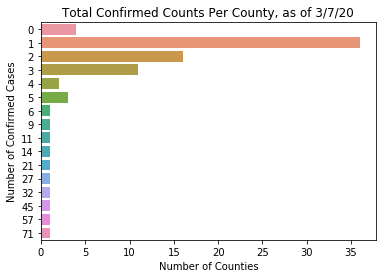

In [8]:
ax = sns.countplot(y="3/7/20", data=covid_us).set_title('Total Confirmed Counts Per County, as of 3/7/20');
plt.ylabel("Number of Confirmed Cases")
plt.xlabel("Number of Counties")
plt.show()

Tranpose the data, to be able to grab just the dates, latitude and longitude associated with new confirmed cases. Data rows above are cumulative.

In [9]:
datevars=[i for i in covid_us if i not in ['Province/State','Country/Region','Lat','Long']]

covid_us_t = pd.melt(covid_us,
                 id_vars=['Province/State',
                          'Country/Region',
                          'Lat',
                          'Long'],
                  value_vars=datevars,
                  var_name='DateCons')

In [10]:
covid_us_t.head()

,Province/State,Country/Region,Lat,Long,DateCons,value
0,"King County, WA",US,47.6062,-122.3321,1/22/20,1
1,"Cook County, IL",US,41.7377,-87.6976,1/22/20,0
2,"Los Angeles, CA",US,34.0522,-118.2437,1/22/20,0
3,"San Benito, CA",US,36.5761,-120.9876,1/22/20,0
4,"Madison, WI",US,43.0731,-89.4012,1/22/20,0


Drop rows that are not associated with confirmed cases.

In [11]:
covid_us_t_pos = covid_us_t[covid_us_t['value']>0]

In [12]:
covid_us_t_pos.head()

,Province/State,Country/Region,Lat,Long,DateCons,value
0,"King County, WA",US,47.6062,-122.3321,1/22/20,1
82,"King County, WA",US,47.6062,-122.3321,1/23/20,1
164,"King County, WA",US,47.6062,-122.3321,1/24/20,1
165,"Cook County, IL",US,41.7377,-87.6976,1/24/20,1
246,"King County, WA",US,47.6062,-122.3321,1/25/20,1


Keep the first date associated with each new confirmed case.

In [13]:
covid2 = covid_us_t_pos.groupby(['Province/State','Country/Region','Lat','Long','value']).nth(0).reset_index()

In [14]:
covid2.head()

,Province/State,Country/Region,Lat,Long,value,DateCons
0,"Norfolk County, MA",US,42.1767,-71.1449,1,3/3/20
1,"Norfolk County, MA",US,42.1767,-71.1449,2,3/6/20
2,"Alameda County, CA",US,37.6017,-121.7195,1,3/3/20
3,"Alameda County, CA",US,37.6017,-121.7195,2,3/7/20
4,"Bergen County, NJ",US,40.9263,-74.0770,2,3/5/20


In [15]:
# to get the full picture. generates a lot of output.
# fullprint(covid2)

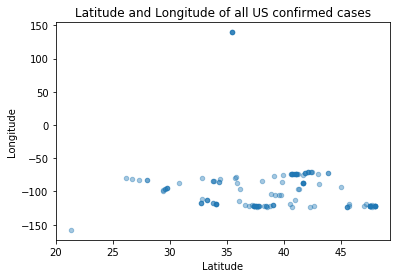

In [16]:
# poor man's map to eyeball check for lat and long outliers
covid2.plot(kind='scatter',x="Lat",y='Long',alpha=0.4).set_title('Latitude and Longitude of all US confirmed cases');
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [17]:
covid2[covid2['Long']>100]

,Province/State,Country/Region,Lat,Long,value,DateCons
130,Unassigned Location (From Diamond Princess),US,35.4437,139.638,36,2/24/20
131,Unassigned Location (From Diamond Princess),US,35.4437,139.638,42,2/26/20
132,Unassigned Location (From Diamond Princess),US,35.4437,139.638,44,2/28/20
133,Unassigned Location (From Diamond Princess),US,35.4437,139.638,45,3/2/20


Remove the confirmed cases from Diamond Princess, regardless of lat and long location. 

In [18]:
covid2_noprincess = covid2[~covid2['Province/State'].str.contains('Princess')].copy(deep=True)

In [19]:
covid2[covid2['Long']<-150]

,Province/State,Country/Region,Lat,Long,value,DateCons
43,"Honolulu County, HI",US,21.307,-157.8584,1,3/7/20


Hawaii's okay. We'll keep them.

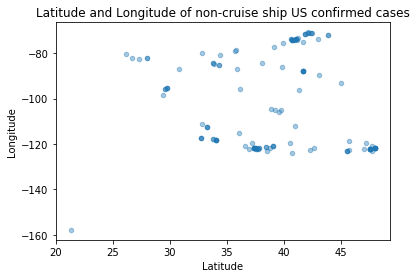

In [20]:
covid2_noprincess.plot(kind='scatter',x="Lat",y='Long',alpha=0.4).set_title('Latitude and Longitude of non-cruise ship US confirmed cases');
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

### Data Source #2: Localized Twitter

#### Data Dictionary
To be refined.
* **0**: Number of likes.
* **1**: Twitter screen name.
* **2**: Tweet text.
* **3**: Tweet timestamp.
* **4**: Twitter username.

TwitterScraper: https://github.com/taspinar/twitterscraper/blob/master/examples/get_twitter_user_data.py  
Says location data can be pulled, if provided.

Making a copy of the data so far.

In [21]:
covidsamp = covid2_noprincess.copy(deep=True)

In [22]:
covidsamp.head(5)

,Province/State,Country/Region,Lat,Long,value,DateCons
0,"Norfolk County, MA",US,42.1767,-71.1449,1,3/3/20
1,"Norfolk County, MA",US,42.1767,-71.1449,2,3/6/20
2,"Alameda County, CA",US,37.6017,-121.7195,1,3/3/20
3,"Alameda County, CA",US,37.6017,-121.7195,2,3/7/20
4,"Bergen County, NJ",US,40.9263,-74.0770,2,3/5/20


In [23]:
covidsamp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 147
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  140 non-null    object 
 1   Country/Region  140 non-null    object 
 2   Lat             140 non-null    float64
 3   Long            140 non-null    float64
 4   value           140 non-null    int64  
 5   DateCons        140 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 7.7+ KB


Set up variables that can be used for looping to pull the data.

In [24]:
covidsamp['tquery'] = "Coronavirus near:"+covid2_noprincess.astype(str)['Lat']+","+covid2_noprincess.astype(str)['Long']+" within:40mi"
covidsamp['lookbackdate'] = pd.to_datetime(covidsamp['DateCons']) - timedelta(days=5)
covidsamp['lookfordate'] = pd.to_datetime(covidsamp['DateCons']) + timedelta(days=5)
covidsamp['byear'] = covidsamp['lookbackdate'].dt.year
covidsamp['bmonth'] = covidsamp['lookbackdate'].dt.month
covidsamp['bday'] = covidsamp['lookbackdate'].dt.day
covidsamp['fyear'] = covidsamp['lookfordate'].dt.year
covidsamp['fmonth'] = covidsamp['lookfordate'].dt.month
covidsamp['fday'] = covidsamp['lookfordate'].dt.day

In [25]:
covidsamp.head(3)

,Province/State,Country/Region,Lat,Long,value,DateCons,tquery,lookbackdate,lookfordate,byear,bmonth,bday,fyear,fmonth,fday
0,"Norfolk County, MA",US,42.1767,-71.1449,1,3/3/20,"Coronavirus near:42.1767,-71.1449 within:40mi",2020-02-27,2020-03-08,2020,2,27,2020,3,8
1,"Norfolk County, MA",US,42.1767,-71.1449,2,3/6/20,"Coronavirus near:42.1767,-71.1449 within:40mi",2020-03-01,2020-03-11,2020,3,1,2020,3,11
2,"Alameda County, CA",US,37.6017,-121.7195,1,3/3/20,"Coronavirus near:37.6017,-121.7195 within:40mi",2020-02-27,2020-03-08,2020,2,27,2020,3,8


Note, this section is skipped to save time on processing. The subsequent step pulls in the data that was scraped. Pulling all of the Twitter data takes a really long time. I would recommend skipping this step and importing the data I already saved out.
If you feel like torturing yourself, you can uncomment rundehdata = 'yes' and it'll do its thing.

In [26]:
rundehdata = 'no'
# rundehdata = 'yes'

In [27]:
if rundehdata == 'yes':
    count = 0
    for (query,byear,bmonth,bday,fyear,fmonth,fday,datecons) in zip(covidsamp['tquery'],covidsamp['byear'],covidsamp['bmonth'],covidsamp['bday'],covidsamp['fyear'],covidsamp['fmonth'],covidsamp['fday'],covidsamp['DateCons']):
        tweet_data = []
        count = count + 1
        
        # pinging twitter does not produce full results, if the queries are being sent too quickly. the count condition below
        # is to rerun loops that were incomplete for this reason.
    #     if count>6 and count<11:
#         if count==82:  
    
        # python likes to yell at me about indenting. obviously we're dealing with less than 10,000 pulls, but this is here as a dummy control for when I 
        # have to rerun some loops.
        if count<10000:
            # set up dynamic file names
            dfname = 'tst' + str(count)
            filepath = './tweetdata/'+dfname+'.csv'
            # pull the twitter data for each query/location/timeframe
            tweets = query_tweets(query,lang='en',begindate=date(byear,bmonth,bday),enddate=date(fyear,fmonth,fday))
            for tweet in tweets:
                tweet_data.append([tweet.likes, tweet.screen_name, tweet.text, tweet.timestamp, tweet.username])
            # put all the tweets in a dataframe
            dfname = pd.DataFrame(tweet_data).drop_duplicates()
            dfname['DateConfirmed'] = datecons
            dfname.columns = ['likes','screenname','tweet','timestamp','username','dateconfirmed']
            dfname.to_csv(filepath)

Bring in just one of the saved datasets to take a look at what we have.

In [28]:
chk = pd.read_csv('./tweetdata/tst90.csv')

In [29]:
chk.tail(3)

,Unnamed: 0,likes,screenname,tweet,timestamp,username,dateconfirmed
3829,4013,0,Newarkguy1973,"This guy is mentally sick. The president has surrounded himself with the top scientists involved with the virus. 18,000 Americans have died from the flu since January. Coronavirus has been out out just as long. Yet, no influenza talk as they normally do this time of year! https://twitter.com/chrislhayes/status/1236492111257755660 …",2020-03-08 03:40:15,Deplorable L Arroyo😆🇺🇸🇵🇷,3/7/20
3830,4014,0,Robderbs,Empty halls. No handshakes. What happens when coronavirus cancels conferences https://www.latimes.com/business/story/2020-03-05/coronavirus-industry-conventions …,2020-03-08 03:38:31,Baseball is (Not) Coming (Yet),3/7/20
3831,4015,0,mariolinton,"World War Z now showing on all CNN, Fox News & BB channels. #coronavirus",2020-03-08 03:37:16,Love to Ride,3/7/20


In [30]:
chk = chk.sort_values('timestamp')

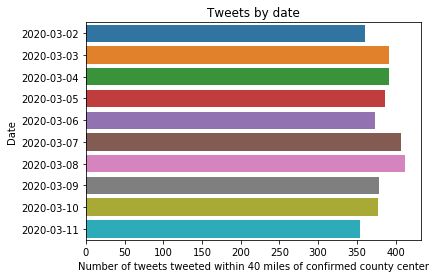

In [31]:
ax = sns.countplot(y=(pd.to_datetime(chk['timestamp']).dt.date), data=chk).set_title('Tweets by date');
plt.ylabel("Date")
plt.xlabel("Number of tweets tweeted within 40 miles of confirmed county center")
plt.show()

As you can see above, there are regions where the overall volume of tweets about coronavirus did not substantially change. I looked at several other regions, but did not include that here for the sake of general redundancy. My original idea for the outcome variable was an increase in the sheer number of tweets, which I later changed in response to what I was seeing in EDA. The new outcome is average fear-based sentiment before and after a new confirmed case.

### Emotion Sentiment Analysis

Emotion sentiment analysis inspiration came from this dude. A lot of the next section is stuff I adapted from his notebook.
https://github.com/raffg/harry_potter_nlp/blob/master/sentiment_analysis.ipynb

Source for NRC emotion lexicon data:
https://github.com/sebastianruder/emotion_proposition_store/tree/master/NRC-Emotion-Lexicon-v0.92

NRC source data was last updated in 2011. There's probably a better, more recent source I can use, but my preliminary research into sentiment analysis indicates that most projects stick with 'positive' and 'negative', vs. actual emotions. Sticking with NRC for now so I can gauge fear.

In [32]:
# bring in raw NDC data and reformat
filepath = ('./tweetdata/NRC-Emotion-Lexicon-Wordlevel-alphabetized-v0.92.txt')
emolex_df = pd.read_csv(filepath,names=["word", "emotion", "association"],sep='\t')
emolex_df = emolex_df[pd.notnull(emolex_df['emotion'])]
emolex_words = emolex_df.pivot(index='word',columns='emotion',values='association').reset_index()
emolex_words = emolex_words[pd.notnull(emolex_words['word'])]
emotions = emolex_words.columns.drop('word')

stemmer = SnowballStemmer("english")

stop_words = stopwords.words('english')
# add in garbage that stopwords doesn't account for, and punctuation.
garbage = ['@','this','2','the','1','The','This','“','”','#','...',':/','#',"'"]
stop_words.extend(garbage)
stop_words.extend(string.punctuation)

tweeter = TweetTokenizer()

In [33]:
emolex_words.head(5)

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
1,aback,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abacus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5,abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


Count the number of tweet data files that were saved out during scraping. This is to allow for looping when tokenizing each dataset. Tokenizing is computationally expensive.

In [34]:
path, dirs, files = next(os.walk('./tweetdata'))
totfiles = len(files)+1
# for testing.
totfiles = 5

I would recommend skipping this next section when running the notebook, for the sake of time. I import the post-processed data in the next step. Just one csv containing a little over 1MB of tweet data (4,742 tweets) takes an hour to tokenize on my machine. I'm currently pulling data for 131 dates associated with new confirmed cases.

There are a number of things happening here for processing each tweet in each dataset:
1. Save out the original tweet, for comparisons
2. Tokenize the tweet
3. Remove stopwords (and, a, the, etc)
4. Assign emotion scores at the word level, based on words in the NRC data
5. Aggregate the emotion scores at the tweet level

In [35]:
rundehdata = 'no'
# rundehdata = 'yes'

In [36]:
%%time

if rundehdata == 'yes':  

#     for x in range(1,totfiles):
    for x in range(124,132):

        fpath = './tweetdata/tst'+str(x)+'.csv'
        df = pd.read_csv(fpath)

#         new_df = df.head(50).copy(deep=True).reset_index()
        new_df = df.copy(deep=True).reset_index()
        emo_df = pd.DataFrame(0, index=df.index, columns=emotions)
    
        new_df['loc'] = x
        
        for i,row in new_df.iterrows():
            dateconfirmed = new_df['dateconfirmed'][i]
            index = new_df['index'][i]
            origtweet = new_df['tweet'][i]
            documenta = tweeter.tokenize(new_df['tweet'][i].replace("#",""))
            # remove stopwords                                                                                         
            document = [x for x in documenta if not x.lower() in stop_words]
            for word in document:
                # get to root words... this did not end up working the way I wanted it to, the stem chopping is sloppy. commented out.
        #         word = stemmer.stem(word.lower())    
                word = word.lower()
                # assign an emotion score for each word
                emo_score = emolex_words[emolex_words.word == word]

                # word frequency + emotion checking
                left = pd.DataFrame({'index':[index],'tweet':[origtweet],'word':[word]})
                right = pd.DataFrame(emo_score)
                newdat = pd.DataFrame(left.merge(right,on='word',how='left'))
#                 checkit = checkit.append(newdat)

                if not emo_score.empty:
                    for emotion in list(emotions):
                        # aggregate scores for the tweet by emotion
                        emo_df.at[i, emotion] += emo_score[emotion]
                        
        outdf = pd.concat([new_df, emo_df], axis=1) 
        
        fpath = './tweetdata/tst'+str(x)+'_processed.csv'
        outdf.to_csv(fpath)

Wall time: 0 ns


Above cell: 18 minutes for 4 data sets

In [37]:
outdf_full = pd.DataFrame()

for x in range(1,132):
    fpath = './tweetdata/tst'+str(x)+'_processed.csv'
    df = pd.read_csv(fpath)
    outdf_full = outdf_full.append(df)

In [38]:
outdf_full.head(2)

,Unnamed: 0,index,Unnamed: 0.1,likes,screenname,tweet,timestamp,username,dateconfirmed,loc,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0,0,0,1,lsferguson,Coronavirus is the new Russia https://twitter.com/MrJones_tm/status/1234252428058484736 …,2020-03-01 23:51:54,Steve Ferguson,3/3/20,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,esgarchitect,"The 2020 picture w #coronavirus effect will make quite the A/B test. We prefer a global world, despite what the nationalists and tribalists try and argue for. Humans meeting humans is the only way to break -isms and othering. #aviation #travel #airtravel #airlines #COVID19 #tradehttps://twitter.com/LaurelCoons/status/1073081733703069696 …",2020-03-01 23:36:18,Graham “flatten the curve” Sinclair,3/3/20,1,1,0,0,0,0,1,1,0,1,1


In [39]:
outdf_full.tail(2)

,Unnamed: 0,index,Unnamed: 0.1,likes,screenname,tweet,timestamp,username,dateconfirmed,loc,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
173,173,173,209,0,magnezi,"The most scarce resource - hand sanitizer. There's none, no where, nada. #Coronavirus #Crazinesspic.twitter.com/aGOO20X5s4",2020-03-06 15:14:17,Kobi-Wan Kenobi,3/7/20,131,0,0,0,1,0,1,0,1,0,0
174,174,174,210,0,SPdx35,@jimcramer $apt $codx should be higher with $8.3B of #COVID19 funds! #coronavirus,2020-03-06 15:05:45,StockPdx35,3/7/20,131,0,0,0,0,0,0,1,0,0,0


In [40]:
def extremes(emotion):
    maxemo = max(outdf_full[emotion])
    exploretweet = outdf_full['index'][outdf_full[emotion]==maxemo].astype(int)
    display(outdf_full[outdf_full[emotion]==maxemo].head(1))

In [41]:
extremes('fear')

,Unnamed: 0,index,Unnamed: 0.1,likes,screenname,tweet,timestamp,username,dateconfirmed,loc,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
2283,2283,2283,2433,0,IsraelRoseMarr1,Hi. I'm not trying to scare people from this deadly virus disease coronavirus. Because this deadly virus disease coronavirus is scarring me.and we have to find a cure. To scare the deadly virus disease coronavirus. For good. God bless us all around the world. pic.twitter.com/uwh8YmZCpe,2020-02-29 15:29:18,Israel Rose Marrero,3/5/20,5,8,5,6,9,3,11,3,6,3,3


In [42]:
extremes('sadness')

,Unnamed: 0,index,Unnamed: 0.1,likes,screenname,tweet,timestamp,username,dateconfirmed,loc,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
2344,2344,2344,2499,3,PeterCorless,"My latest $0.02 on #coronavirus / #coronanoia. This is not the flu. It is also not the Black Death or zombie apocalypse. It will be somewhere in between those extremes, and it's gonna hurt bad. U.S. alone: 327k to 16m may die depending on morbidity/mortality. Check my math.pic.twitter.com/HemjO3xfJT",2020-03-10 03:35:34,Peter Corless 🌎☮,3/7/20,4,5,1,3,7,0,8,0,7,1,0


What are the most common words?

In [43]:
# ax = sns.countplot(y=checkit_full['word'], data=checkit_full,order=checkit_full['word'].value_counts().iloc[:20].index).set_title('Tweet words');
# plt.ylabel("")
# plt.xlabel("")
# plt.show()

In [44]:
import dateutil.parser

outdf_full_copy = outdf_full.copy(deep=True)
outdf_full_copy['datestampa'] = pd.to_datetime(outdf_full_copy['timestamp'])
outdf_full_copy['datestampb'] = outdf_full_copy['datestampa'].dt.date

Before = outdf_full_copy[outdf_full_copy['datestampb']<pd.to_datetime(outdf_full_copy['dateconfirmed']).dt.date]
After = outdf_full_copy[outdf_full_copy['datestampb']>pd.to_datetime(outdf_full_copy['dateconfirmed']).dt.date]

In [45]:
BeforeM = pd.DataFrame(Before.groupby(['loc'])[emotions].mean())
AfterM = pd.DataFrame(After.rename(columns={'fear':'fear2'}).groupby(['loc'])['fear2'].mean())

In [46]:
BeforeM.head(2)

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
loc,,,,,,,,,,
1,0.449176,0.526099,0.304945,0.722527,0.335165,1.211538,1.046703,0.527473,0.412088,0.699176
2,0.424754,0.528833,0.291139,0.686357,0.327707,1.097046,1.053446,0.527426,0.354430,0.720113


In [47]:
AfterM.head(2)

,fear2
loc,
1,0.647779
2,0.656319


In [48]:
atloc = pd.DataFrame(BeforeM.merge(AfterM,on='loc',how='left'))
atloc['fearincrease'] = (atloc['fear2'] > atloc['fear']).astype(int)

In [49]:
atloc.head(2)

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,fear2,fearincrease
loc,,,,,,,,,,,,
1,0.449176,0.526099,0.304945,0.722527,0.335165,1.211538,1.046703,0.527473,0.412088,0.699176,0.647779,0
2,0.424754,0.528833,0.291139,0.686357,0.327707,1.097046,1.053446,0.527426,0.354430,0.720113,0.656319,0


In [50]:
atloc[atloc['fearincrease']==1].head(3)

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,fear2,fearincrease
loc,,,,,,,,,,,,
6,0.281250,0.437500,0.218750,0.510417,0.291667,0.906250,1.010417,0.312500,0.239583,0.593750,0.611111,1
7,0.347826,0.456522,0.260870,0.456522,0.358696,1.163043,0.836957,0.456522,0.358696,0.489130,0.540541,1
9,0.376344,0.612903,0.311828,0.591398,0.344086,1.021505,0.924731,0.354839,0.354839,0.709677,0.652778,1


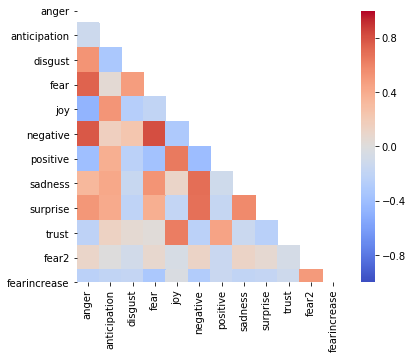

In [51]:
corr = atloc.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(6,5))
sns.heatmap(corr,vmin=-1,cmap='coolwarm',mask=mask);

### Prep & Baseline Accuracy

In [52]:
X = atloc[['anger','anticipation','disgust','fear','joy','sadness','surprise','trust']]
y = atloc['fearincrease']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=202)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
y_test.value_counts(normalize=True)

0    0.757576
1    0.242424
Name: fearincrease, dtype: float64

### Model 1: Logistic Regression

In [54]:
logreg = LogisticRegression()

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [ ]:
best_model = clf.fit(X_train, y_train)

In [56]:
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


In [57]:
lr2 = LogisticRegression(C=1,penalty="l1")
lr2.fit(X_train,y_train)
y_hat_train = lr2.predict(X_train)

C:\Users\laure\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [58]:
confusion_matrix(y_train,y_hat_train)

array([[63,  6],
       [15, 14]], dtype=int64)

In [59]:
y_hat_test = lr2.predict(X_test)
confusion_matrix(y_test,y_hat_test)

array([[25,  0],
       [ 5,  3]], dtype=int64)

In [60]:
display(lr2.score(X_train, y_train))
display(lr2.score(X_test, y_test))

0.7857142857142857

0.8484848484848485

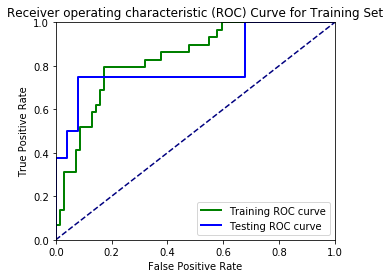

In [61]:
y_train_score = lr2.predict_proba(X_train)[:,1]
y_test_score = lr2.predict_proba(X_test)[:,1]

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_test_score)

plt.figure(figsize=(5, 4))
plt.plot(train_fpr, train_tpr, color='green', lw=2, label='Training ROC curve')
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label='Testing ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic (ROC) Curve for Training Set')

plt.legend(loc=4)
plt.show();

### Model 2: KNN

In [62]:
k_range = list(range(1, 40))

training_error = []
testing_error = []

for k in k_range:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred_class = knn.predict(X_train)
    training_accuracy = metrics.accuracy_score(y_train, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [63]:
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K')
df.sort_values('testing error').head(1)

,training error,testing error
K,,
2,0.163265,0.151515


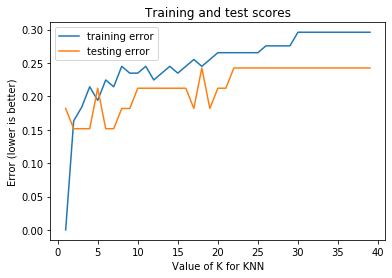

In [64]:
df.plot(figsize=(6, 4), title='Training and test scores');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [65]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

In [66]:
display(knn.score(X_train, y_train))
display(knn.score(X_test, y_test))

0.8367346938775511

0.8484848484848485

In [67]:
y_hat_train = knn.predict(X_train)
confusion_matrix(y_train,y_hat_train)

array([[69,  0],
       [16, 13]], dtype=int64)

In [68]:
y_hat_test = knn.predict(X_test)
confusion_matrix(y_test,y_hat_test)

array([[25,  0],
       [ 5,  3]], dtype=int64)

### Model 3: Gradient Boosting Classifier

In [69]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2,3,4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(gboost, param_grid=gboost_params, cv=3)
gb_gs.fit(X_train, y_train)

C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [70]:
gb_gs.best_score_

0.7040816326530612

In [71]:
gb_gs.best_params_

{'learning_rate': 0.08, 'max_depth': 2, 'n_estimators': 125}

In [72]:
gboost = GradientBoostingClassifier(learning_rate=0.08, max_depth=2, n_estimators=100)
gboost.fit(X_train, y_train)
y_pred_class = gboost.predict(X_test)

In [73]:
display(gboost.score(X_train, y_train))
display(gboost.score(X_test, y_test))

1.0

0.8181818181818182

In [74]:
y_hat_train = gboost.predict(X_train)
confusion_matrix(y_train,y_hat_train)

array([[69,  0],
       [ 0, 29]], dtype=int64)

In [75]:
y_hat_test = gboost.predict(X_test)
confusion_matrix(y_test,y_hat_test)

array([[23,  2],
       [ 4,  4]], dtype=int64)

### Model 4: Decision Tree Classifier

In [76]:
dt = DecisionTreeClassifier()
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(dt, tree_para, cv=5)
clf.fit(X_train, y_train)

C:\Users\laure\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 

In [77]:
clf.best_score_

0.6938775510204082

In [78]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 90}

In [79]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=90)
dt.fit(X_train, y_train)
y_pred_class = dt.predict(X_test)

In [80]:
display(dt.score(X_train, y_train))
display(dt.score(X_test, y_test))

1.0

0.696969696969697

In [81]:
y_hat_train = dt.predict(X_train)
confusion_matrix(y_train,y_hat_train)

array([[69,  0],
       [ 0, 29]], dtype=int64)

In [82]:
y_hat_test = dt.predict(X_test)
confusion_matrix(y_test,y_hat_test)

array([[19,  6],
       [ 4,  4]], dtype=int64)